In [6]:
print("Prediksi dengan Multihead atention neural network")

Prediksi dengan Multihead atention neural network


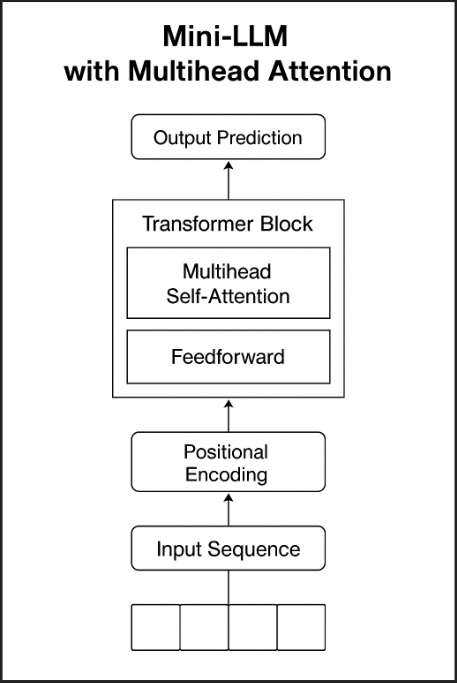

Teks Input →
Embedding →
Positional Encoding →
Multihead Attention →
Feedforward →
Linear Output →
Prediksi Token Selanjutnya ✅
<br>
Pada dasarnya, Mini-LLM bekerja dengan menerima input berupa teks, seperti kalimat <i>“i love machine learning”.</i> Kalimat ini terlebih dahulu diubah menjadi representasi angka (token) melalui proses tokenisasi. Setiap kata akan diganti dengan ID tertentu berdasarkan kamus yang telah dibuat sebelumnya. Setelah itu, token-token ini masuk ke dalam Embedding Layer, yang bertugas mengubah setiap ID menjadi vektor berdimensi tinggi. Representasi ini memungkinkan model memahami makna kata dalam bentuk numerik. Namun, karena model Transformer tidak mengenali urutan kata secara alami, maka vektor dari embedding tersebut akan ditambahkan informasi posisi melalui Positional Encoding. Ini penting agar model tahu urutan kata mana yang datang lebih dulu atau belakangan dalam kalimat.

Selanjutnya, vektor-vektor yang telah diperkaya dengan posisi ini akan masuk ke inti utama model, yaitu Multihead Self-Attention. Di bagian ini, setiap kata “melihat” kata-kata lain dalam kalimat untuk menentukan mana yang paling relevan atau penting untuk dipahami dalam konteks kalimat. Karena menggunakan banyak kepala (multihead), model dapat menangkap berbagai pola relasi dalam satu waktu — seperti hubungan semantik, kata kunci, atau posisi kata. Hasil dari perhatian ini kemudian diproses oleh Feedforward Layer, yaitu jaringan saraf lanjutan yang memperkuat dan menyaring informasi penting yang telah diperoleh.

Akhirnya, hasil dari proses feedforward akan masuk ke Layer Output, di mana model akan memetakan informasi tersebut menjadi prediksi token selanjutnya. Misalnya, setelah membaca “i love machine learning”, model akan mencoba memprediksi bahwa kata berikutnya adalah “and” berdasarkan pola-pola yang telah ia pelajari. Proses ini memungkinkan model untuk membuat prediksi teks yang lebih akurat dan kontekstual, layaknya LLM seperti GPT dalam versi sederhana.

In [1]:
import torch
import torch.nn as nn

class MultiHeadPredictionModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim)
        )

    def forward(self, x):
        x = self.embedding(x)  # [batch, seq_len, embed_dim]
        attn_output, _ = self.attention(x, x, x)
        out = self.ff(attn_output[:, -1, :])  # Prediksi hanya dari posisi terakhir
        return out


In [2]:
model = MultiHeadPredictionModel(input_dim=1, embed_dim=64, num_heads=4, ff_dim=128, output_dim=1)
x = torch.randn(32, 10, 1)  # batch 32, sequence 10, 1 feature
pred = model(x)
print(pred.shape)  


torch.Size([32, 1])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


Load dataset text dan Tokenisasi

In [21]:
text = "i love you so much and very need you to be my future wife"

# Buat vocabulary
words = list(set(text.split()))
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(word2idx)

# Tokenisasi
tokens = [word2idx[word] for word in text.split()]

# Buat pasangan (input, target) untuk next word prediction
seq_length = 4
X, y = [], []
for i in range(len(tokens) - seq_length):
    X.append(tokens[i:i+seq_length])
    y.append(tokens[i+seq_length])

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)


Potisional encoding

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


Model mini LLM

In [23]:
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim)
        self.attn = nn.TransformerEncoderLayer(embed_dim, num_heads, ff_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(self.attn, num_layers=2)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.encoder(x)
        return self.fc_out(x[:, -1, :])  # untuk mengambil token terakhir


Training data

In [24]:
model = MiniGPT(vocab_size, embed_dim=64, num_heads=2, ff_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 20, Loss: 0.0034
Epoch 40, Loss: 0.0008
Epoch 60, Loss: 0.0006
Epoch 80, Loss: 0.0004
Epoch 100, Loss: 0.0003
Epoch 120, Loss: 0.0003
Epoch 140, Loss: 0.0002
Epoch 160, Loss: 0.0002
Epoch 180, Loss: 0.0002
Epoch 200, Loss: 0.0002


Predict the next word's

In [28]:
def predict_next(model, input_text):
    model.eval()
    tokens = [word2idx[w] for w in input_text.split()]
    x = torch.tensor(tokens).unsqueeze(0)
    with torch.no_grad():
        out = model(x)
        pred_idx = torch.argmax(out, dim=-1).item()
    return idx2word[pred_idx]

# Contoh prediksi
input_text = "i love"
print("Next word prediction:", predict_next(model, input_text))


Next word prediction: much
